In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss 
import altair as alt

# Reading tables and resetting index after sorting with ID column

In [2]:
df1=pd.read_csv("subject-info.csv")
df2=pd.read_csv("test_measure.csv")
sub=df1.copy()
test=df2.copy()
sub=sub.sort_values(by='ID')
test=test.sort_values(by=['ID','time'])
sub.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

## 49.Identify the test name that had the shortest time duration.

In [3]:
# Find total duration for each test
test_durations = test.groupby('ID_test')['time'].max()

 #this helps to get the index value that has a minimum value in series
min_test_id = test_durations.idxmin()
# shortest duration and its respective ID
min_duration = test_durations.min()

print(f"Shortest test ID: {min_test_id}")
print(f"Duration: {min_duration} seconds")

Shortest test ID: 564_1
Duration: 495 seconds


## 50.What is the percentage difference in mean Carbon dioxide production between male and female athletes?

In [131]:
#merge sub and test on the ID column
merged_tab = pd.merge(test, sub, on=['ID','ID_test'], how='inner')

#Drop rows with missing VCO2 or Sex
merged = merged_tab.dropna(subset=['VCO2', 'Sex'])

#Find mean Carbondioxide of male and female
mean_C = merged.groupby('Sex')['VCO2'].mean()

vco2_female = mean_C[1]  # Sex = 1 → Female
vco2_male = mean_C[0]    # Sex = 0 → Male
print(f"Mean VCO2 (Male): {vco2_male:.2f} mL/min")
print(f"Mean VCO2 (Female): {vco2_female:.2f} mL/min")
print(f'Percentage Difference:{abs(vco2_male - vco2_female) / ((vco2_male + vco2_female) / 2) * 100:.2f} %')

Mean VCO2 (Male): 2487.79 mL/min
Mean VCO2 (Female): 1724.72 mL/min
Percentage Difference:36.23 %


## 51.Calculate the Fitness Index, generate a bar chart of Fitness Index categories, and export it as SVG file.

### Fitness Index= VO₂ (mL/min) / HR (beats/min)

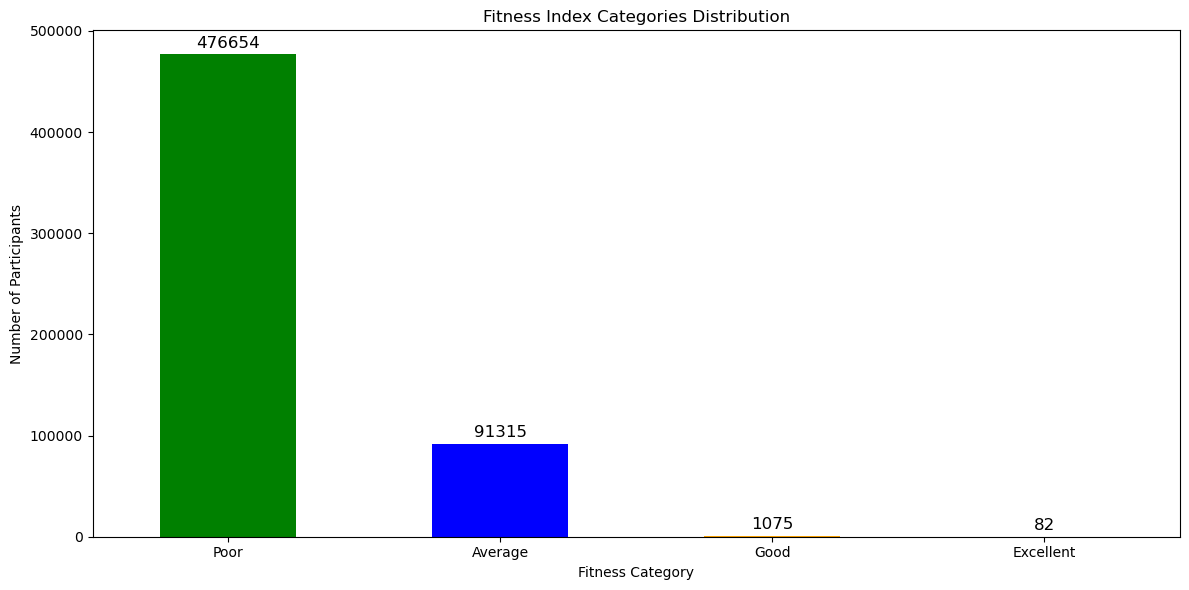

In [391]:
#drop where VO2 and HR is null
merged=merged_tab.copy()
merged=merged.dropna(subset=['VO2' , 'HR'])
#calculate fitness index column
merged.loc[:,'Fitness_index']= merged['VO2']/merged['HR']

#define a function to categorize fitness index as >40=Excellent >30=Good >20 = average <20 poor
def fitness_categ(fitness_index):
    if fitness_index>40:
        return "Excellent"
    elif fitness_index>30:
        return "Good"
    elif fitness_index>20:
        return "Average"
    else:
        return "Poor"

#Apply the above function to Fitness_index column of merged dataset
merged.loc[:,"Fitness_category"]=merged['Fitness_index'].apply(fitness_categ)

# Count the number of participants in each fitness category
category_counts = merged['Fitness_category'].value_counts()
#print(category_counts)

# Plot the bar chart of fitness categories
plt.figure(figsize=(12, 6))
ax=category_counts.plot(kind='bar', color=['green', 'blue', 'orange', 'red'])

# Add counts over the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext=(0, 5),  # Offset the label slightly above the bar
               textcoords='offset points',
                ha='center', 
                #va='bottom', 
                fontsize=12, color='black')
plt.title('Fitness Index Categories Distribution')
plt.xlabel('Fitness Category')
plt.ylabel('Number of Participants')
plt.xticks(rotation=0)
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig('fitness_index_categories.svg', format='svg')

# Show the plot
plt.show()

## 52.arr=np.array([
##    [3, 5, 7, 9],   
##    [2, 0, 8, 10],  
##    [1, 4, 8, 12],  
##   [5, 9, 14, 15]  
##                 ] )
## Transpose this numpy matrix. and calculate sum of each row after transposing. Find the row with highest sum(after transposing)

In [239]:
#transpose an array
arr=np.array([
    [3, 5, 7, 9],   
    [2, 0, 8, 10],  
    [1, 4, 8, 12],  
    [5, 9, 14, 15]  
] )
Transpose_array= arr.T
print(f"Transposed array:\n{Transpose_array}")

# Calculating the sum of each row
row_sums = Transpose_array.sum(axis=1)

# This returns the index of the row with the highest sum
row_max_sum=row_sums.argmax()
print(f"Row with index value {row_max_sum} has highest sum")


Transposed array:
[[ 3  2  1  5]
 [ 5  0  4  9]
 [ 7  8  8 14]
 [ 9 10 12 15]]
Row with index value 3 has highest sum


## 53.Display participant details with highest average cardiorespiratory fitness in terms of VO2 max.

In [308]:
# Calculate the average VO2max per participant
average_vo2max = merged.groupby('ID')['VO2'].mean()

# Find the ID with the highest average VO2
max_VO2_id = average_vo2max.idxmax()

#Function to name the Gender
def gender(sex):
    if sex==0:
        return "F"
    else:
        return "M"

#Create Gender colum in merged table
merged_tab.loc[:,'Gender']=merged['Sex'].apply(gender)

# Get the row with the participant details for the highest average VO2max, selecting only specific columns
participant_details = merged_tab[merged_tab['ID'] == max_VO2_id][['ID', 'Age', 'Height', 'Weight', 'Gender']].iloc[0]

print(participant_details)

ID          409
Age        23.6
Height    190.0
Weight     86.0
Gender        F
Name: 273285, dtype: object


## 54.calculate the heart rate reserve and show the distribution as density plot 
Heart Rate reserve(HRR)=HR(max)-HR(rest).
HR(max)=220 approx.
HR(rest)= You can define it as the minimum heart rate observed during the test per participant/test.


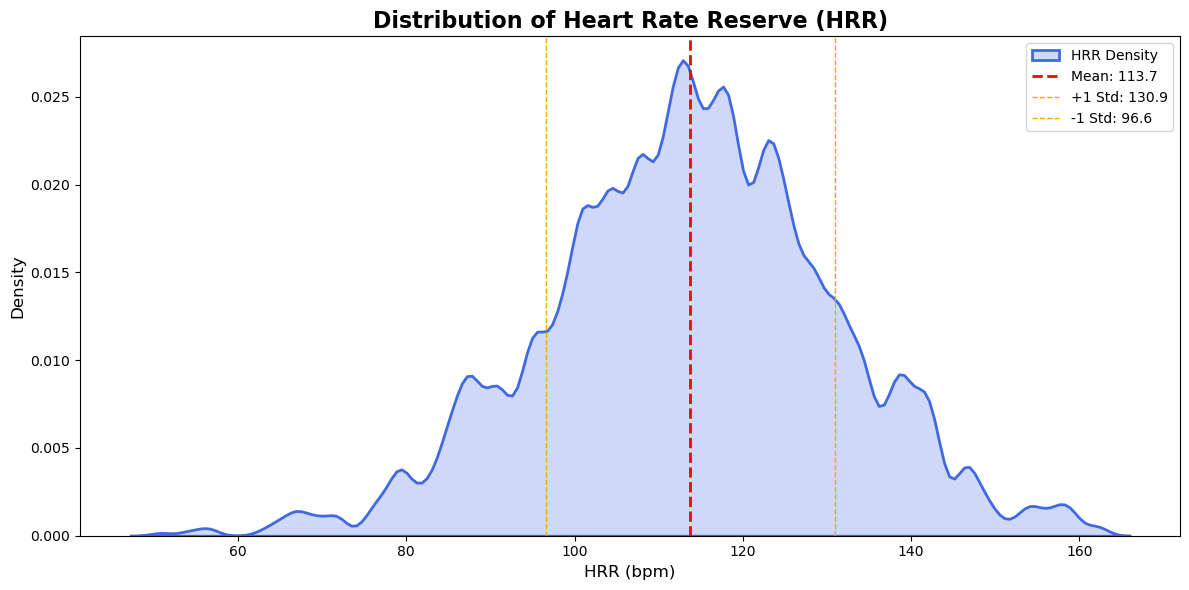

In [372]:
merged_tab = pd.merge(test, sub, on=['ID','ID_test'], how='inner')

merged_tab['HR_max'] = 220 - merged_tab['Age']

# Step 2: Compute HR_rest (minimum HR per test)
hr_rest_per_test = merged_tab.groupby('ID_test')['HR'].min().reset_index()

#rename HR to HR_rest
hr_rest_per_test.rename(columns={'HR': 'HR_rest'}, inplace=True)

# Step 3: Merge HR_rest back into merged_tab
merged_tab = pd.merge(merged_tab, hr_rest_per_test, on='ID_test', how='left')
merged_tab['HRR'] = merged_tab['HR_max'] - merged_tab['HR_rest']

#Density Plot
hrr_data = merged_tab['HRR'].dropna()

# Calculate mean and std
hrr_mean = hrr_data.mean()
hrr_std = hrr_data.std()

# Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(hrr_data, fill=True, color='royalblue', linewidth=2, label='HRR Density')

# Add mean and ±1 std lines
plt.axvline(hrr_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {hrr_mean:.1f}')
plt.axvline(hrr_mean + hrr_std, color='orange', linestyle='--', linewidth=1, label=f'+1 Std: {hrr_mean + hrr_std:.1f}')
plt.axvline(hrr_mean - hrr_std, color='orange', linestyle='--', linewidth=1, label=f'-1 Std: {hrr_mean - hrr_std:.1f}')

# Labels and title
plt.title('Distribution of Heart Rate Reserve (HRR)', fontsize=16, fontweight='bold')
plt.xlabel('HRR (bpm)', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Style
plt.grid(visible=False)
plt.legend()
plt.tight_layout()
plt.show()

## 55.Create a boxplot comparing heart rates between males and females, showing hue as speed category.

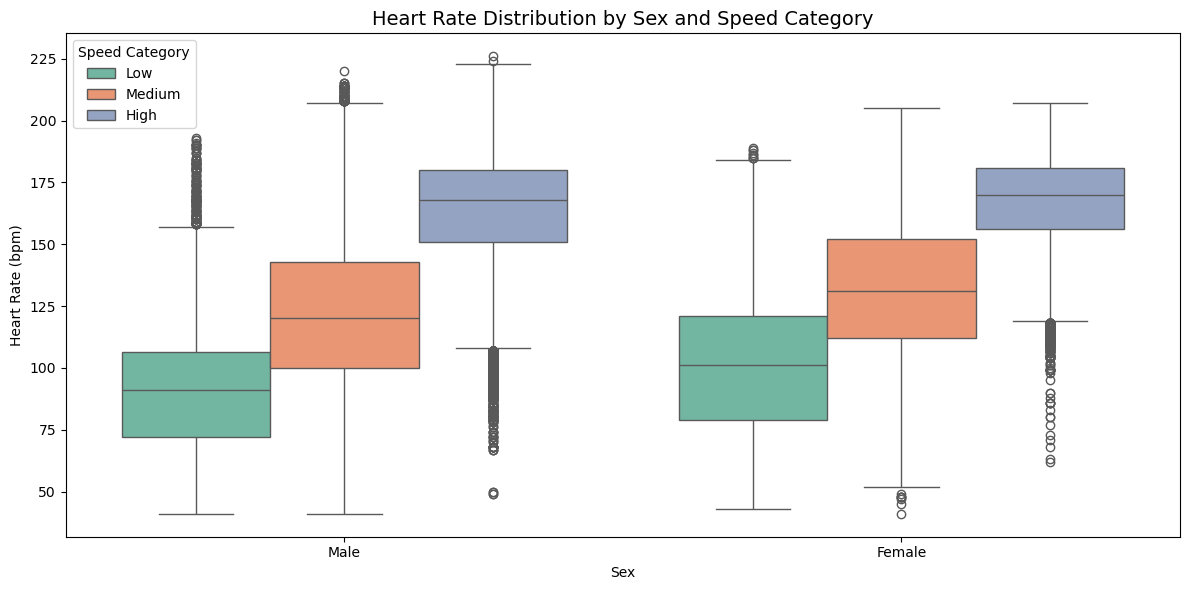

In [377]:
# Define func for Speed Categories
def speed_category(speed):
    if speed < 4:
        return 'Low'
    elif speed < 8:
        return 'Medium'
    else:
        return 'High'

merged_tab['Speed_cat'] = merged_tab['Speed'].apply(speed_category)

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_tab, x='Sex', y='HR', hue='Speed_cat', palette='Set2')

#formatting
plt.xticks([0, 1], ['Male', 'Female'])  # 0 = Male, 1 = Female
plt.title('Heart Rate Distribution by Sex and Speed Category', fontsize=14)
plt.xlabel('Sex')
plt.ylabel('Heart Rate (bpm)')
plt.legend(title='Speed Category')
plt.grid(False)
plt.tight_layout()
plt.show()

## 56.Choose any feature that follows a Gaussian distribution, convert it into a standard normal distribution, and visualize the results?

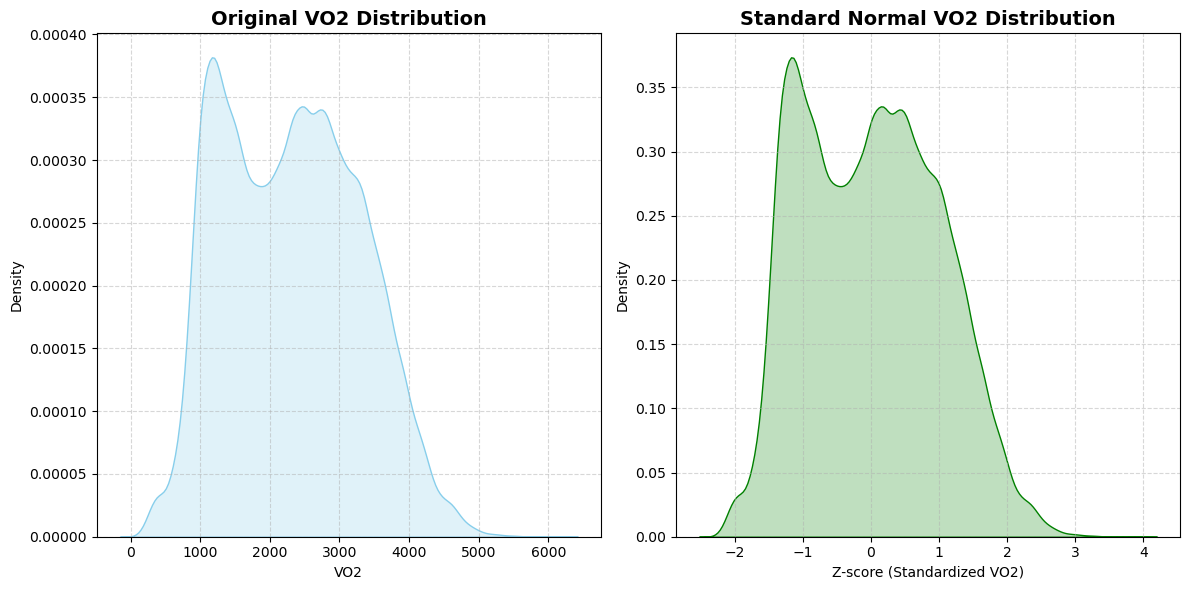

In [393]:
# 1. Drop missing values from the selected feature
vo2_data = merged_tab['VO2'].dropna()

# 2. Convert to standard normal using z-score
vo2_standardized = ss.zscore(vo2_data)

# 3. Plot original vs standardized
plt.figure(figsize=(12, 6))

# Original distribution
plt.subplot(1, 2, 1)
sns.kdeplot(vo2_data, fill=True, color='skyblue')
plt.title('Original VO2 Distribution', fontsize=14, fontweight='bold')
plt.xlabel('VO2')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)

# Standardized normaldistribution
plt.subplot(1, 2, 2)
sns.kdeplot(vo2_standardized, fill=True, color='green')
plt.title('Standard Normal VO2 Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Z-score (Standardized VO2)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 57. Identify the participant who has taken maximum number of Graded Exercise test and justify.

In [435]:
#participant count
Participant_test_count = sub['ID'].value_counts().reset_index()

Participant_test_count.columns = ['ID', 'Participant_test_count']
ID_max=Participant_test_count.loc[Participant_test_count['Participant_test_count'].idxmax()]
print(f'participant with max GET test:\n{ID_max}')

participant with max GET test:
ID                        506
Participant_test_count      5
Name: 0, dtype: int64


## 58.For participant ID 725 show trend of  any three variables against time in a single canva ?

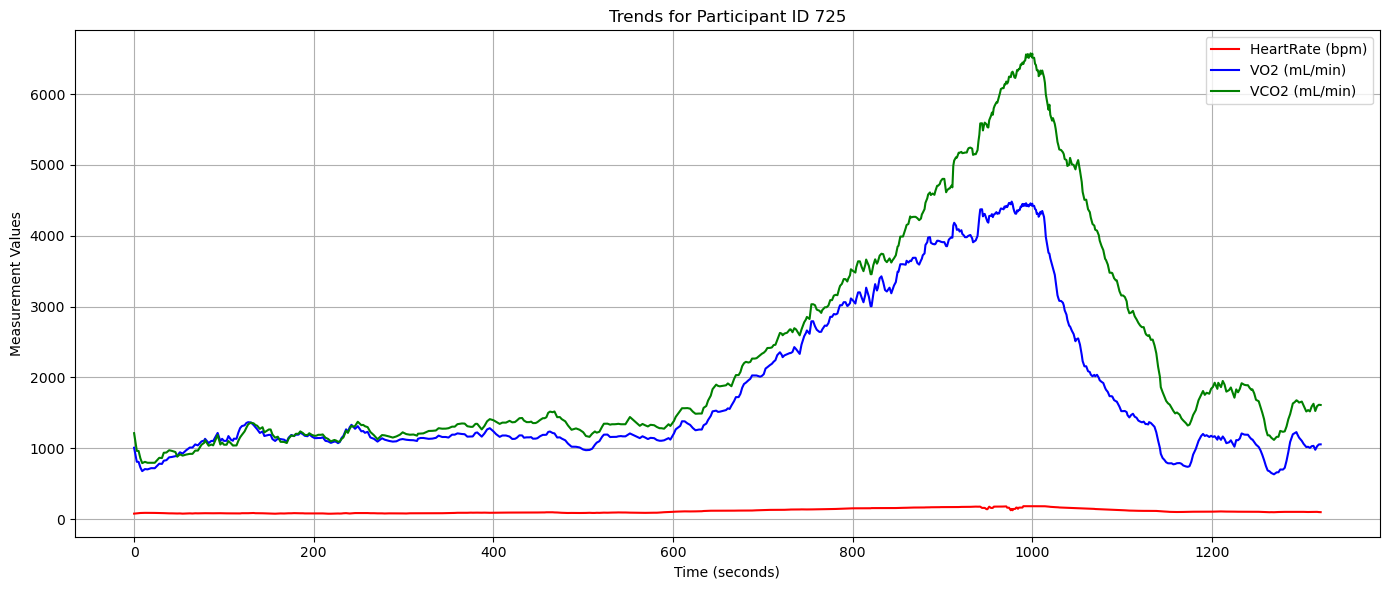

In [468]:
participant_725 = test[test['ID'] == 725]

plt.figure(figsize=(14, 6))

# Plot Heart Rate
plt.plot(participant_725['time'], participant_725['HR'], label='HeartRate (bpm)', color='red')

# Plot VO2
plt.plot(participant_725['time'], participant_725['VO2'], label='VO2 (mL/min)', color='blue')

# Plot Speed
plt.plot(participant_725['time'], participant_725['VCO2'], label='VCO2 (mL/min)', color='green')

#formatting chart
plt.title('Trends for Participant ID 725')
plt.xlabel('Time (seconds)')
plt.ylabel('Measurement Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 59.Create a scatter plot with a regression line using Altair, take a random sample data with features 'x' and 'y'.

In [471]:
pip install altair pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
print('test')

test
